In [1]:
import argparse
from math import log10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.cuda as cuda

import time
import numpy as np
import os
from RANet_lib import *
from RANet_lib.RANet_lib import *
from RANet_model import RANet as Net
import os
import os.path as osp
from glob import glob

import matplotlib.pyplot as plt
from torchvision import transforms
import PIL.Image as Image

In [2]:
from vj_davis_17_loader import Custom_DAVIS2017_dataset
from torch.utils.data import DataLoader
from vj_loss_functions import *
# from vj_RAnet_models import Full_training_RAnet

In [3]:
torch.cuda.device_count()

1

In [4]:
net_name = 'RANet'
parser = argparse.ArgumentParser(description='RANet')
parser.add_argument('--deviceID', default=[0], help='device IDs')
parser.add_argument('--threads', type=int, default=16, help='number of threads for data loader to use')
parser.add_argument('--workfolder', default='../models/')
parser.add_argument('--savePName', default=net_name)
parser.add_argument('--net_type', default='single_object')
parser.add_argument('--fp16', default=True)
print('===> Setting ......')
# opt = parser.parse_args()
class args:
    pass
opt = args()
# opt.deviceID = [0]
opt.threads=0
opt.workfolder='../models/'
opt.savePName = net_name
opt.net_type='single_object'
opt.fp16=False

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

try:
    os.mkdir(opt.workfolder)
    print('build working folder: ' + opt.workfolder)
except:
    print(opt.workfolder + 'exists')


print('===> Building model')
############## Choose a model #################
# params='RANet_video_multi.pth'
# params='RANet_encoder_retrain_epoch1.pth'
# params='RANet_multi_basic_train_epoch1.pth'
params = 'RANet_video_multi.pth'

dataset='17train'
save_root='../predictions/RANet_Video_17val'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpus = [i for i in range(torch.cuda.device_count())]
# gpus = [0]
print('using GPUs ID: {}'.format(gpus))

model = Net(pretrained=False, type=opt.net_type)
inSize1 = 480
inSize2 = 864
if dataset in ['16val', '16trainval', '16all']:
    model.set_type('single_object')
    year = '2016'
elif dataset in ['17val', '17test_dev', '17train']:
    model.set_type('multi_object')
    year = '2017'
else:
    assert('dataset error')
checkpoint_load(opt.workfolder + params, model)

# if opt.deviceID==[0]:
#     model_cuda = model.cuda()
# else:
#     model_cuda = nn.DataParallel(model).cuda()
# if opt.fp16:
#     model_cuda = model_cuda.half()
#     model_cuda.fp16 = True

root = '../datasets/DAVIS'
img_mode = '480p'
img_shape = (inSize1,inSize2)

===> Setting ......
../models/exists
===> Building model
using GPUs ID: [0]
Single-object mode
Change to multi-object mode
=> Loaded checkpoint '../models/RANet_video_multi.pth'


In [5]:
from vj_data_parallel_model import Full_training_RAnet

In [6]:
full_model = Full_training_RAnet(model, loss_classifier=normal_jaccard_loss_with_logits,\
                lamda1=0.5, lamda2=0.5, cross_lamda=2, lamda=0.1)

decoder_parameters = []
encoder_parameters = []
for name, param in model.named_parameters():
    if ('base_model' not in name and 'L3' not in name and 'L4' not in name and 'L_g' not in name):
        decoder_parameters.append(param)
    else:
        if ('base_model' not in name):
            print("encoder param:", name)
        encoder_parameters.append(param)

optimizer_encoder = torch.optim.Adam(encoder_parameters, lr=1e-02)
optimizer_decoder = torch.optim.Adam(decoder_parameters, lr=1e-02)
# optimizer_wholemodel = torch.optim.Adam(model.parameters(), lr=0)

loss_per_epoch = []
full_model = nn.DataParallel(full_model, device_ids=gpus).cuda()
# full_model.to(device)
model.train()
print("full mode in cuda, memory used so far:",cuda.memory_allocated(0) /(1024*1024))

encoder param: L4.2.weight
encoder param: L4.2.bias
encoder param: L3.2.weight
encoder param: L3.2.bias
encoder param: L_g.2.weight
encoder param: L_g.2.bias
full mode in cuda, memory used so far: 246.2900390625


In [5]:

img_dataset = Custom_DAVIS2017_dataset(root=root, img_shape=img_shape, img_mode=img_mode,\
                                       get_prev_mask=False, use_std_template=False)
img_loader = DataLoader(dataset=img_dataset, num_workers=0, batch_size=1*len(gpus), shuffle=False, pin_memory=True)
print("Image loader ready")

loading files from:  ../datasets/DAVIS/ImageSets/2017/train.txt
Image loader ready


In [11]:
for iteration, batch in enumerate(img_loader, 1):
    template,template_mask, target,target_mask = batch
    if (iteration > 3):
        break

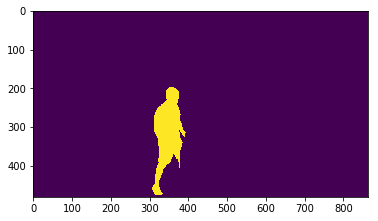

In [26]:
idx = 0
m2 = template_mask[idx: idx + 1]
max_obj = m2.max().int().data.cpu().numpy()
M2s = model.P2masks(F.relu(m2 - 1), max_obj - 1)
plt.imshow((M2s[3][0,0]).numpy())

In [28]:
max_obj

array(4, dtype=int32)

In [22]:
M2s[0].shape

torch.Size([1, 1, 480, 864])

In [8]:
print(model.Ranking[1].conv1.weight[:3,:3,0].data)
print(model.L3[2].weight[:3,:3,0].data)

tensor([[[-0.0088],
         [ 0.0506],
         [-0.0579]],

        [[-0.0658],
         [-0.0541],
         [-0.0322]],

        [[-0.0613],
         [-0.0427],
         [-0.0469]]], device='cuda:0')
tensor([[[-0.0029, -0.0158, -0.0020],
         [-0.0018,  0.0101,  0.0033],
         [ 0.0026, -0.0086, -0.0037]],

        [[ 0.0010, -0.0157, -0.0049],
         [-0.0038, -0.0093,  0.0057],
         [-0.0096, -0.0059, -0.0070]],

        [[-0.0045,  0.0085,  0.0006],
         [ 0.0048, -0.0033,  0.0020],
         [-0.0066, -0.0101, -0.0047]]], device='cuda:0')


In [9]:
import pickle
saved_training_info = './train_info.pkl'
try:
    with open(saved_training_info, 'rb') as f:
        loss_per_epoch = pickle.load(f)
    print("loaded prev info, epochs run:", len(loss_per_epoch))
    loss_per_epoch = loss_per_epoch.tolist()
except:
    loss_per_epoch = []

loaded prev info, epochs run: 1


In [10]:

# template,template_mask, target,target_mask = batch
# template = template.unsqueeze(1)
# template_mask = template_mask.unsqueeze(1)
# target = target.unsqueeze(1)
# target_mask = target_mask.unsqueeze(1)

In [12]:
max_memory_usage = 0
for epoch in range(1):
    start_time = time.perf_counter()
    loss_per_batch = []
    model_train_time = 0
    
    for iteration, batch in enumerate(img_loader, 1):
        template,template_mask, target,target_mask = batch
        template = template
        template_mask = template_mask
        target = target
        target_mask = target_mask
        
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        start_time_model = time.perf_counter()
        loss = full_model(template, target, template_mask, target_mask, disc_scale=0.5)
        total_loss, cls_loss, correlation_loss = loss.mean(dim=0)

        total_loss= total_loss.mean()
        if np.isnan(total_loss.item()):
            print("Nan value for loss!, breaking")
            asdsad
        
        if(cuda.memory_allocated(0) /(1024*1024)>max_memory_usage):
            max_memory_usage = cuda.memory_allocated(0) /(1024*1024)
            print("max memory usage so far:", max_memory_usage, "epoch:", epoch, "iter:", iteration)
        #### Do backprop #####
        total_loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()

        if(type(correlation_loss) is type(0.1)):
            loss_per_batch.append([total_loss.item(), cls_loss.item(),correlation_loss ])
        else:
            loss_per_batch.append([total_loss.item(), cls_loss.item(),correlation_loss.item() ])
        
        model_train_time += time.perf_counter() - start_time_model
        
        
    loss_per_batch = np.array(loss_per_batch)
    loss_per_epoch.append(np.mean(loss_per_batch, axis=0))
    
    end_time = time.perf_counter()
    memory = cuda.memory_allocated(0) /(1024*1024)
    checkpoint_save(opt.workfolder + 'RANet_multi_temp', 1, model)

    with open(saved_training_info, 'wb') as f:
        pickle.dump(loss_per_epoch, f)
    print("epoch:", epoch, "loss:",loss_per_epoch[-1][0], "Time for mini batch:", end_time - start_time,\
          "time spend on model running:",model_train_time,\
          "memory used",memory)

max memory usage so far: 4121.4072265625 epoch: 0 iter: 1
max memory usage so far: 4769.9794921875 epoch: 0 iter: 2
max memory usage so far: 8688.0380859375 epoch: 0 iter: 3
Checkpoint saved to ../models/RANet_multi_temp_epoch1.pth
epoch: 0 loss: 0.5829015562931696 Time for mini batch: 71.71138437599802 time spend on model running: 34.845475806010654 memory used 1011.8720703125


In [29]:
new_ranking_weight =model.Ranking[1].conv1.weight.clone()
new_net_weight =model.L3[2].weight[:3,:3,0].clone()

In [31]:
print((old_ranking_weight-new_ranking_weight).abs().sum())
print((new_net_weight-old_net_weight).abs().sum())

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.8341, device='cuda:0', grad_fn=<SumBackward0>)


In [9]:
import pickle
saved_training_info = './training_info/train_info_IOU_trnsfm_disc_scale05_nms.pkl'
try:
    with open(saved_training_info, 'rb') as f:
        loss_per_epoch = pickle.load(f)
    print("loaded prev info, epochs run:", len(loss_per_epoch))
#     loss_per_epoch.tolist()
except:
    loss_per_epoch = []

loaded prev info, epochs run: 691


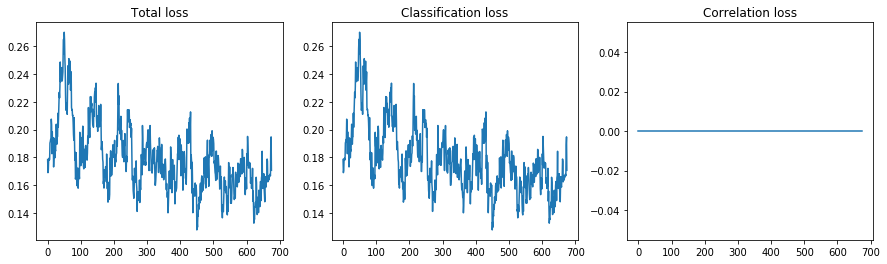

In [7]:
loss_per_epoch = np.array(loss_per_epoch)
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title("Total loss")
plt.plot(loss_per_epoch[:,0])
plt.subplot(1,3,2)
plt.title("Classification loss")
plt.plot(loss_per_epoch[:,1])
plt.subplot(1,3,3)
plt.title("Correlation loss")
plt.plot(loss_per_epoch[:,2])
plt.show()

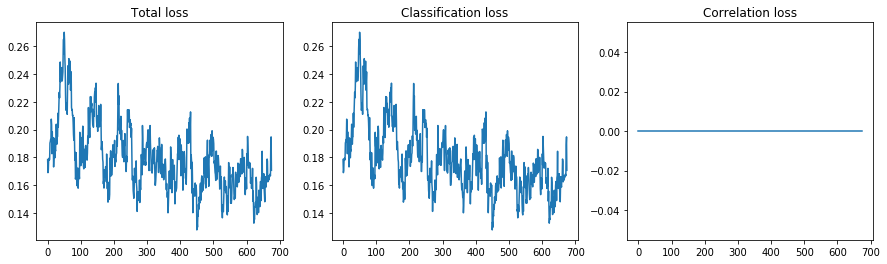

In [8]:

loss_per_epoch = np.array(loss_per_epoch)
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title("Total loss")
plt.plot(loss_per_epoch[:,0])
plt.subplot(1,3,2)
plt.title("Classification loss")
plt.plot(loss_per_epoch[:,1])
plt.subplot(1,3,3)
plt.title("Correlation loss")
plt.plot(loss_per_epoch[:,2])
plt.show()

In [7]:

img_dataset = Custom_DAVIS2017_dataset(root=root, img_shape=img_shape, img_mode=img_mode,loader_type='train')

loading files from:  ../datasets/DAVIS/ImageSets/2017/train.txt


In [8]:
img_dataset.names[3]

'boxing-fisheye'

In [9]:
model2 = Net(pretrained=False, type=opt.net_type)
inSize1 = 480
inSize2 = 864

model2.set_type('multi_object')
#RANet_multi_IOU_loss_train_encoder_finetuned_epoch1
#RANet_multi_IOU_loss_train_not_encoder_epoch1.pth
#RANet_video_multi
#RANet_video_multi_BCE_epoch1.pth
checkpoint_load(opt.workfolder + 'RANet_video_multi.pth', model2)
scale_factor2 = 0
model2.cuda()
model2.eval()
print("model2 ready")

Single-object mode
Change to multi-object mode
=> Loaded checkpoint '../models/RANet_video_multi.pth'
model2 ready


In [10]:

checkpoint_load(opt.workfolder + 'RANet_video_multi_BCE_epoch3.pth', model)
scale_factor1 = 0.5
model.cuda()
model.eval()
print("model ready")

=> Loaded checkpoint '../models/RANet_video_multi_BCE_epoch3.pth'
model ready


In [34]:
# img_dataset.video_counter = 28
# name = img_loader.names[28]
# img_loader.img_counter[name]

index = int(np.random.random()*60)%len(img_dataset.names)
index = 3
for i in range(60):
    template,template_mask, target,target_mask = img_dataset.__getitem__(index)
    template = template.cuda().unsqueeze(0)
    template_mask = template_mask.cuda().unsqueeze(0)
    target = target.cuda().unsqueeze(0)
    target_mask = target_mask.cuda().unsqueeze(0)
    print("selected video:", index, "name:",img_dataset.names[index], "objects:", template_mask.max().item() )

    start_time_model = time.perf_counter()
    with torch.no_grad():
        Out, corr_loss_batch = model.RANet_Multiple_forward_train(template=template,target=target,\
                                        template_msk=template_mask, target_msk = target_mask, scale_factor=scale_factor1)
        Out2, corr_loss_batch = model2.RANet_Multiple_forward_train(template=template,target=target,\
                                        template_msk=template_mask, target_msk = target_mask, scale_factor=scale_factor2)



    loss1, loss2 =0,0
    for j in range(len(Out[0][0])):
        loss1 += custom_BCELoss_with_logits(Out[0][0,j].reshape(1,-1),\
                                   target_mask[0,0:1].eq(j+2).reshape(1,-1).float()).item()
        loss2 += custom_BCELoss_with_logits(Out2[0][0,j].reshape(1,-1),\
                                   target_mask[0,0:1].eq(j+2).reshape(1,-1).float()).item()
    print("Custom retrained_loss: %.4f, original_loss: %.4f"%(loss1,loss2))

    loss1, loss2 =0,0
    for j in range(len(Out[0][0])):
        loss1 += normal_BCELoss_with_logits(Out[0][0,j].reshape(1,-1),\
                                   target_mask[0,0:1].eq(j+2).reshape(1,-1).float()).item()
        loss2 += normal_BCELoss_with_logits(Out2[0][0,j].reshape(1,-1),\
                                   target_mask[0,0:1].eq(j+2).reshape(1,-1).float()).item()
    print("Normal retrained_loss: %.4f, original_loss: %.4f"%(loss1,loss2))

    loss1, loss2 =0,0
    for j in range(len(Out[0][0])):
        loss1 += normal_jaccard_loss_with_logits(Out[0][0,j].reshape(1,-1),\
                                   target_mask[0,0:1].eq(j+2).reshape(1,-1).float()).item()
        loss2 += normal_jaccard_loss_with_logits(Out2[0][0,j].reshape(1,-1),\
                                   target_mask[0,0:1].eq(j+2).reshape(1,-1).float()).item()
    print("Jaccard retrained_loss: %.4f, original_loss: %.4f"%(loss1,loss2))
    if (loss2 < loss1):
        break

i = -1

selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.2567, original_loss: 0.1644
Normal retrained_loss: 0.0202, original_loss: 0.0247
Jaccard retrained_loss: 0.2972, original_loss: 0.3681
selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.3009, original_loss: 0.1995
Normal retrained_loss: 0.0217, original_loss: 0.0277
Jaccard retrained_loss: 0.3633, original_loss: 0.4079
selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.3124, original_loss: 0.2147
Normal retrained_loss: 0.0214, original_loss: 0.0343
Jaccard retrained_loss: 0.3786, original_loss: 0.4931
selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.2333, original_loss: 0.2284
Normal retrained_loss: 0.0175, original_loss: 0.0261
Jaccard retrained_loss: 0.3241, original_loss: 0.4056
selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.2736, original_loss: 0.1795
Normal retrained_loss: 0.0178, original_loss: 0

selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.3115, original_loss: 0.1813
Normal retrained_loss: 0.0183, original_loss: 0.0270
Jaccard retrained_loss: 0.4796, original_loss: 0.6257
selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.3266, original_loss: 0.1791
Normal retrained_loss: 0.0164, original_loss: 0.0267
Jaccard retrained_loss: 0.4785, original_loss: 0.6344
selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.3248, original_loss: 0.2162
Normal retrained_loss: 0.0205, original_loss: 0.0305
Jaccard retrained_loss: 0.5597, original_loss: 0.6631
selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.3639, original_loss: 0.2155
Normal retrained_loss: 0.0180, original_loss: 0.0257
Jaccard retrained_loss: 0.5312, original_loss: 0.6283
selected video: 3 name: boxing-fisheye objects: 4.0
Custom retrained_loss: 0.4068, original_loss: 0.2399
Normal retrained_loss: 0.0172, original_loss: 0

In [16]:
target_mask[0,0:1].max()

tensor(4., device='cuda:0')

In [17]:
len(Out[0][0])

3

Custom retrained_loss: 0.2234, original_loss: 0.1208
Normal retrained_loss: 0.0163, original_loss: 0.0215
Jaccard retrained_loss: 0.2657, original_loss: 0.3047


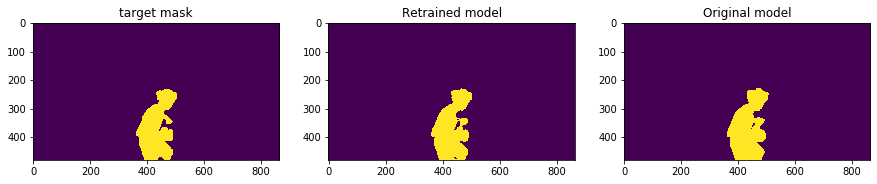

In [31]:
i = (i+1)%(len(Out[0][0]))
# i=7
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.title("target mask")
plt.imshow(target_mask[0,0].detach().cpu().numpy()==(i+2))
plt.subplot(1,3,2)
plt.imshow(torch.sigmoid(Out[0][0,i]).detach().cpu().ge(0.5).numpy())
plt.title("Retrained model")
plt.subplot(1,3,3)
plt.imshow(torch.sigmoid(Out2[0][0,i]).detach().cpu().ge(0.5).numpy())
plt.title("Original model")

In [23]:
normal_jaccard_loss_with_logits(Out[0][0,j].reshape(1,-1),\
                               target_mask[0,0:1].eq(j+2).reshape(1,-1).float())

tensor(0.0791, device='cuda:0')

This is to check how the correlation difference is helping

In [16]:
img_loader.video_counter = 0
template,template_mask, target,target_mask = img_dataset.__getitem__(4)
template = template.cuda()
template_mask = template_mask.cuda()
target = target.cuda()
target_mask = target_mask.cuda()

self=model
template=template.unsqueeze(0)
target=target.unsqueeze(0)
template_msk=template_mask.unsqueeze(0)
target_msk=target_mask.unsqueeze(0)
f=F
scale_factor = 0

In [17]:
def get_images(self, template, target, template_msk, target_msk):
    with torch.no_grad():
        base_features2 = self.res_forward(template)
        Kernel_3 = f.normalize(f.max_pool2d(self.L3(base_features2[2]), 2))
        Kernel_4 = f.normalize(self.L4(base_features2[3]))
        Kernel_5 = f.normalize(f.interpolate(self.L5(base_features2[4]), scale_factor=2, mode='bilinear',align_corners=True))
        Kernel_tmp = f.normalize(self.L_g(torch.cat([Kernel_3, Kernel_4, Kernel_5], dim=1)))
        Kernel = Kernel_tmp

        # Current frame feature
        base_features1 = self.res_forward(target)
        Feature_3 = f.normalize(f.max_pool2d(self.L3(base_features1[2]), 2))
        Feature_4 = f.normalize(self.L4(base_features1[3]))
        Feature_5 = f.normalize(f.interpolate(self.L5(base_features1[4]), scale_factor=2, mode='bilinear',align_corners=True))
        Feature = f.normalize(self.L_g(torch.cat([Feature_3, Feature_4, Feature_5], dim=1)))

        Out_Rs = []

        basef1 = torch.cat([self.ls13(base_features1[2]),
                            self.ls14(base_features1[3]),
                            self.ls15(base_features1[4]), ], 1)
        basef2 = torch.cat([self.ls22(base_features1[1]),
                            self.ls23(base_features1[2]),
                            self.ls24(base_features1[3]), ], 1)
        basef3 = torch.cat([self.ls31(base_features1[0]),
                            self.ls32(base_features1[1]),
                            self.ls33(base_features1[2])], 1)
        loss_per_batch = []
        for idx in range(len(Feature)):  # batch
            ker = Kernel_tmp[idx: idx + 1]
            feature = Feature[idx: idx + 1]
            m2 = template_msk[idx: idx + 1]
            m1 = target_msk[idx: idx + 1]

            max_obj = m2.max().int().data.cpu().numpy()
            if max_obj < 2:
                m2[0, 0, 0, 0] = 2
                max_obj = m2.max().int().data.cpu().numpy()
            M2s = self.P2masks(f.relu(m2 - 1), max_obj - 1)
            M2_all = m2.ge(1.5).float()
            M1s = self.P2masks(f.relu(m1 - 1), max_obj - 1)
            M1_all = m1.ge(1.5).float()

            # Correlation
            W0, H0 = ker.size()[-2::]
            W,H = feature.size()[-2::]
            Corr_subs = []
            ker_R = self.to_kernel(ker)
            corr_R = self.correlate(ker_R, feature)

            template_self_corr = self.correlate(ker_R, ker)
            target_self_corr = self.correlate(self.to_kernel(feature), feature)

            # Ranking attention scores
            T_corr =  f.max_pool2d(corr_R,2).view(-1, W0*H0, W*H//4).transpose(1, 2).view(-1, W*H//4, W0, H0)
            R_map = f.relu(self.Ranking(T_corr)) * 0.2
            Rmaps = []


            for idy in range(max_obj):  # make corrs (backgrounds(=1) and objs)
                m2_rep = f.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])
                corr_sub = m2_rep.view(m2_rep.size()[0], -1, 1, 1) * corr_R
                Corr_subs.append(corr_sub)
                Rmaps.append((R_map * m2_rep).view(-1, 1, W0*H0))

            Outs = []
            loss_per_obj = []
            for idy in range(1, max_obj):  # training:with_bg, testing: w/o BG
                corr = Corr_subs[idy]
                co_size = Corr_subs[idy].size()[2::]
                max_only, indices = f.max_pool2d(corr, co_size, return_indices=True)
                max_only = max_only.view(-1, 1, W0*H0) + Rmaps[idy]

                #### For FG, adjust scores based on how close a pixel is to rest of the FG pixes and far away from BG pixels
                # Self correlation is of size: batch_size x W*H x W x H
                # We want the final score to be a score on each pixel and thus of dimension: batch_size x W*H x 1 x 1
                # Notation meaning: FG_BG: For WxH map with FG pixels, the channels have non zerovalue where 
                #                   channel id corresponds to BG != 0
                m2_rep = f.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])

                ############# Loss for adjusting feature extractor
                loss_obj_dict = {}
                loss_obj_dict['template_FB_FB_loss'] = 0
                loss_obj_dict['template_FB_BG_loss'] = 0
                loss_obj_dict['target_FB_FB_loss'] = 0
                loss_obj_dict['target_FB_BG_loss'] = 0
                loss_obj_dict['tt_FB_FB_loss'] = 0
                loss_obj_dict['tt_FB_BG_loss'] = 0
                ######### For each FG pixel, find closest 5 pixels in FG and sum them up. That is the -ve loss for FG-FG
                num_pixels= 5
                ############################## Just template frame
                m2_rep_pos = m2_rep.ge(0.5).float()
                m2_rep_neg = m2_rep.le(0).float()
                if (self.fp16):
                    m2_rep_pos = m2_rep_pos.half()
                    m2_rep_neg = m2_rep_pos.half()
                indices = torch.nonzero(m2_rep_pos.reshape(-1))
                if (len(indices)>0):
                    temp_corr = torch.cat([template_self_corr[:,index,:] for index in indices], dim=1)
                    FB_FB_loss = (temp_corr*m2_rep_pos).reshape(1,-1,W0*H0)
                    FB_FB_loss, _ = FB_FB_loss.sort(descending=True, dim=2)
                    FB_FB_loss = FB_FB_loss[:,:,:num_pixels]

                    FB_BG_loss = (temp_corr*m2_rep_neg).reshape(1,-1,W0*H0)
                    FB_BG_loss, _ = FB_BG_loss.sort(descending=True, dim=2)
                    FB_BG_loss = FB_BG_loss[:,:,:num_pixels]

                    FB_FB_loss = FB_FB_loss.sum()/(len(indices)*num_pixels)
                    FB_BG_loss = FB_BG_loss.sum()/(len(indices)*num_pixels)
                    del _
                else:
                    FB_FB_loss = 0
                    FB_BG_loss = 0

                loss_obj_dict['template_FB_FB_loss'] = -FB_FB_loss
                loss_obj_dict['template_FB_BG_loss'] = FB_BG_loss

                del indices

                ############################## Just target frame
                m1_rep = f.adaptive_avg_pool2d(M1s[idy], ker.size()[-2::])
                m1_rep_pos = m1_rep.ge(0.5).float()
                m1_rep_neg = m1_rep.le(0).float()
                if (self.fp16):
                    m1_rep_pos = m1_rep_pos.half()
                    m1_rep_neg = m1_rep_pos.half()
                indices = torch.nonzero(m1_rep_pos.reshape(-1))
                if (len(indices)>0):
                    temp_corr = torch.cat([target_self_corr[:,index,:] for index in indices], dim=1)
                    FB_FB_loss = (temp_corr*m1_rep_pos).reshape(1,-1,W*H)
                    FB_FB_loss, _ = FB_FB_loss.sort(descending=True, dim=2)
                    FB_FB_loss = FB_FB_loss[:,:,:num_pixels]

                    FB_BG_loss = (temp_corr*m1_rep_neg).reshape(1,-1,W*H)
                    FB_BG_loss, _ = FB_BG_loss.sort(descending=True, dim=2)
                    FB_BG_loss = FB_BG_loss[:,:,:num_pixels]

                    FB_FB_loss = FB_FB_loss.sum()/(len(indices)*num_pixels)
                    FB_BG_loss = FB_BG_loss.sum()/(len(indices)*num_pixels)
                    del _
                else :
                    FB_FB_loss = 0
                    FB_BG_loss = 0

                loss_obj_dict['target_FB_FB_loss'] = -FB_FB_loss
                loss_obj_dict['target_FB_BG_loss'] = FB_BG_loss
                del indices

                ############################## Between template and target
                ######### Skip this if there are too many objects
                if (max_obj < 5):
                    #### Between FG of template and FG of target
                    # corr_R is of shape: batch_size x W0*H0 x W x H

                    # We want FG of both to be close and FG-BG of both to be far
                    FB_FB_loss = (corr_R*m1_rep_pos).reshape(-1,W0*H0,W*H)
                    indices1 = torch.nonzero(m1_rep_pos.reshape(-1))
                    indices2 = torch.nonzero(m2_rep_pos.reshape(-1))
                    corr_R_transpose = corr_R.view(-1, W0*H0, W*H).transpose(1, 2).view(-1, W*H, W0, H0)

                    if (len(indices1)>0):
                        FB_FB_loss1, _ = FB_FB_loss.squeeze().transpose(0,1).sort(descending=True, dim=1)
                        FB_FB_loss1 = torch.cat([FB_FB_loss1[index,:num_pixels] for index in indices1], dim=0)
                        FB_FB_loss1 = FB_FB_loss1.sum()/(len(indices1)*num_pixels)

                        FB_BG_loss1 = (corr_R_transpose*m1_rep_neg).reshape(-1,W*H,W0*H0)
                        FB_BG_loss1, _ = FB_BG_loss1.squeeze().sort(descending=True, dim=1)
                        FB_BG_loss1 = torch.cat([FB_BG_loss1[index,:num_pixels] for index in indices1], dim=0)
                        FB_BG_loss1 = FB_BG_loss1.sum()/(len(indices1)*num_pixels)
                        del _
                    else:
                        FB_FB_loss1 = 0
                        FB_BG_loss1 = 0

                    if (len(indices2)>0):
                        FB_FB_loss2, _ = FB_FB_loss.squeeze().sort(descending=True, dim=1)
                        FB_FB_loss2 = torch.cat([FB_FB_loss2[index,:num_pixels] for index in indices2], dim=0)
                        FB_FB_loss2 = FB_FB_loss2.sum()/(len(indices2)*num_pixels)

                        FB_BG_loss2 = (corr_R*m2_rep_neg).reshape(-1,W0*H0,W*H)
                        FB_BG_loss2, _ = FB_BG_loss2.squeeze().sort(descending=True, dim=1)
                        FB_BG_loss2 = torch.cat([FB_BG_loss2[index,:num_pixels] for index in indices2], dim=0)
                        FB_BG_loss2 = FB_BG_loss2.sum()/(len(indices2)*num_pixels)
                        del _
                    else:
                        FB_FB_loss2 = 0
                        FB_BG_loss2 = 0

                    loss_obj_dict['tt_FB_FB_loss'] = -(FB_FB_loss1 + FB_FB_loss2)/2
                    loss_obj_dict['tt_FB_BG_loss'] = (FB_BG_loss1 + FB_BG_loss2)/2
                    del indices1,indices2

                loss_per_obj.append(loss_obj_dict)

                # Score addition for machting to FG a lot and penalty for matching to BG
                # We are computing FG discriminant score
                # For each pixel in WxH, we can take max or average across non zero channels

                num_pixels = 5
    #                 print("template_self_corr shape:",template_self_corr.shape,"m2 rep shape:", m2_rep.shape)
                temp_corr = template_self_corr * m2_rep.view(1,W0*H0,1,1)
                FG_disc_score = (temp_corr*m2_rep).reshape(1,-1,W0*H0)
                FG_disc_score, _ = FG_disc_score.sort(descending=True, dim=2)
                FG_disc_score = FG_disc_score[:,:,:num_pixels]
                FG_disc_score = FG_disc_score.sum(dim=2)/(num_pixels)

                FG_neg_score = (temp_corr*(1-m2_rep)).reshape(1,-1,W0*H0)
                FG_neg_score, _ = FG_neg_score.sort(descending=True, dim=2)
                FG_neg_score = FG_neg_score[:,:,:num_pixels]
                FG_neg_score = FG_neg_score.sum(dim=2)/(num_pixels)
                FG_disc_score -= FG_neg_score*0
                del _

                max_only = max_only + FG_disc_score.view(-1,1,W0*H0)*scale_factor
                #########  Addition by VJ done #################

                # Rank & select FG
                m_sorted, m_sorted_idx = max_only.sort(descending=True, dim=2)
                corr = torch.cat([co.index_select(0, m_sort[0, 0:256]).unsqueeze(0) for co, m_sort in zip(corr, m_sorted_idx)])
                # Merge net FG
                corr_fores = self.p_2(self.res_1(self.p_1(f.interpolate(corr, scale_factor=2, mode='bilinear',align_corners=True))))
                if max_obj == 1:  # only bg
                    print('missing obj')
                    corr_backs = torch.zeros(corr_fores.size()).cuda()
                else:
                    '''
                    backs_idx = Corr_subs[0:idy] + Corr_subs[idy + 1::]
                    corr_b = torch.cat(backs_idx, 1)
                    R_map_b = Rmaps[0:idy] + Rmaps[idy + 1::]
                    R_map_b = torch.cat(R_map_b, 2)
                    '''
                    m2_rep = f.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])
                    corr_b = (1-m2_rep.view(m2_rep.size()[0], -1, 1, 1) )* corr_R
                    R_map_b = (R_map * (1-m2_rep)).view(-1, 1, W0*H0)
                    ########## Above added by VJ ###########

                    max_only_b, indices = f.max_pool2d(corr_b, co_size, return_indices=True)
                    max_only_b = max_only_b.view(R_map_b.size()[0], 1, -1) + R_map_b

                    ########################################### VJ
                    num_pixels = 5
                    temp_corr = template_self_corr * (1-m2_rep.view(1,W0*H0,1,1))
                    BG_disc_score = (temp_corr*(1-m2_rep)).reshape(1,-1,W0*H0)
                    BG_disc_score, _ = BG_disc_score.sort(descending=True, dim=2)
                    BG_disc_score = BG_disc_score[:,:,:num_pixels]
                    BG_disc_score = BG_disc_score.sum(dim=2)/(num_pixels)

                    BG_neg_score = (temp_corr*m2_rep).reshape(1,-1,W0*H0)
                    BG_neg_score, _ = BG_neg_score.sort(descending=True, dim=2)
                    BG_neg_score = BG_neg_score[:,:,:num_pixels]
                    BG_neg_score = BG_neg_score.sum(dim=2)/(num_pixels)
                    BG_disc_score -= BG_neg_score*0
                    del _

                    max_only_b = max_only_b + BG_disc_score*scale_factor
                    ############################################ VJ

                    # Rank & select BG
                    m_sorted, m_sorted_idx = max_only_b.sort(descending=True, dim=2)
                    corr_b = torch.cat([co.index_select(0, m_sort[0, 0:256]).unsqueeze(0) for co, m_sort in zip(corr_b, m_sorted_idx)])
                    # Merge net BG
                    corr_backs = self.p_2(self.res_1(self.p_1(f.interpolate(corr_b, scale_factor=2, mode='bilinear',align_corners=True))))
                if idy == 0:
                    tmp = corr_fores
                    corr_fores = corr_backs
                    corr_backs = tmp
                    m_2 = f.adaptive_avg_pool2d(M2_all, corr_fores.size()[-2::])
                else:
                    m_2 = f.adaptive_avg_pool2d(M2s[idy], corr_fores.size()[-2::])
                # low level features
                base1 = torch.cat([basef1[idx: idx + 1], corr_fores, corr_backs, m_2], 1)
                fea1 = self.R1(base1)
                base2 = torch.cat([basef2[idx: idx + 1],
                                   fea1], 1)
                fea2 = self.R2(base2)
                base3 = torch.cat([basef3[idx: idx + 1],
                                   fea2], 1)
                fea3 = self.R3(base3)
    #                 out = torch.sigmoid(fea3)
                out = fea3
    return out.clone().detach().cpu(), max_only.clone().detach().cpu(), FG_disc_score.clone().detach().cpu(),\
            FG_neg_score.clone().detach().cpu(), max_only_b.clone().detach().cpu(),\
            BG_disc_score.clone().detach().cpu(),BG_neg_score.clone().detach().cpu(),loss_obj_dict

In [18]:

checkpoint_load(opt.workfolder + 'RANet_multi_IOU_loss_train_epoch1.pth', model)


out, max_only, FG_disc_score, FG_neg_score ,max_only_b,BG_disc_score, BG_neg_score,loss_obj_dict = \
        get_images(model, template, target, template_msk, target_msk)

model2 = Net(pretrained=False, type=opt.net_type)
inSize1 = 480
inSize2 = 864

model2.set_type('multi_object')
# params='RANet_video_multi.pth'
# params='RANet_encoder_retrain_epoch1.pth'
# # params='RANet_multi_basic_train_epoch1.pth', RANet_multi_IOU_loss_train_epoch1
checkpoint_load(opt.workfolder + 'RANet_encoder_retrain_epoch1.pth', model2)
model_cuda2 = model2.cuda()

out2, max_only2, FG_disc_score2, FG_neg_score2 ,max_only_b2, BG_disc_score2, BG_neg_score2, loss_obj_dict2 = \
        get_images(model2, template, target, template_msk, target_msk)

W0,H0 = 30,54
W,H = 30,54

=> Loaded checkpoint '../models/RANet_multi_IOU_loss_train_epoch1.pth'
Single-object mode
Change to multi-object mode
=> Loaded checkpoint '../models/RANet_encoder_retrain_epoch1.pth'


Text(0.5, 1.0, 'Background2 neg score')

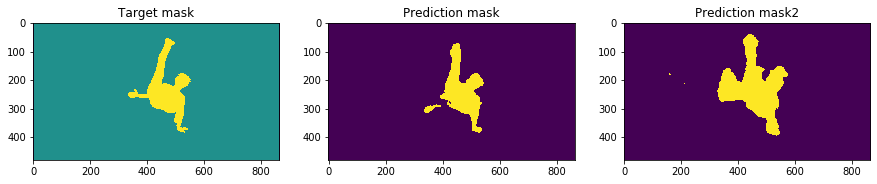

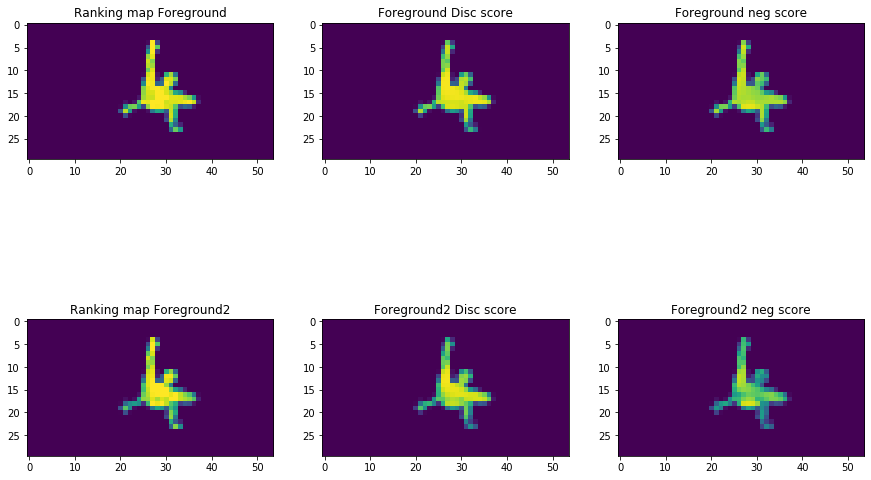

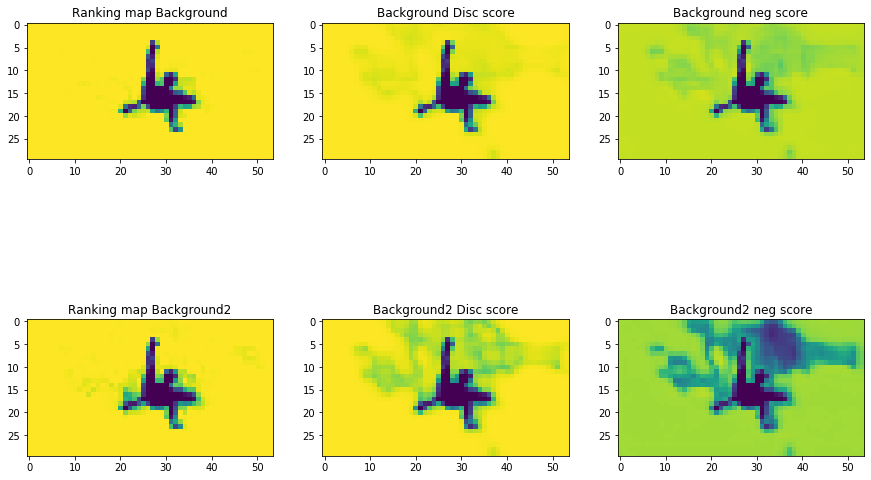

In [21]:


plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(target_mask[0].detach().cpu().numpy()/target_mask.max().item(),vmin=0, vmax=1)
plt.title("Target mask")
plt.subplot(1,3,2)
plt.imshow(torch.sigmoid(out[0,0]).ge(0.5).numpy(),vmin=0, vmax=1)
plt.title("Prediction mask")
plt.subplot(1,3,3)
plt.imshow(torch.sigmoid(out2[0,0]).ge(0.5).numpy(),vmin=0, vmax=1)
plt.title("Prediction mask2")

############### Foreground ###################
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(max_only.reshape(W0,H0).detach().cpu().numpy(),vmin=0, vmax=1)
plt.title("Ranking map Foreground")
plt.subplot(2,3,2)
plt.imshow(FG_disc_score.reshape(W0,H0).detach().cpu().numpy(),vmin=0, vmax=1)
plt.title("Foreground Disc score")
plt.subplot(2,3,3)
plt.imshow(FG_neg_score.reshape(W0,H0).detach().cpu().numpy(),vmin=0, vmax=1)
plt.title("Foreground neg score")

plt.subplot(2,3,4)
plt.imshow(max_only2.reshape(W0,H0).numpy(),vmin=0, vmax=1)
plt.title("Ranking map Foreground2")
plt.subplot(2,3,5)
plt.imshow(FG_disc_score2.reshape(W0,H0).numpy(),vmin=0, vmax=1)
plt.title("Foreground2 Disc score")
plt.subplot(2,3,6)
plt.imshow(FG_neg_score2.reshape(W0,H0).numpy(),vmin=0, vmax=1)
plt.title("Foreground2 neg score")

############## Background ##############

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(max_only_b.reshape(W0,H0).detach().cpu().numpy(),vmin=0, vmax=1)
plt.title("Ranking map Background")
plt.subplot(2,3,2)
plt.imshow(BG_disc_score.reshape(W0,H0).detach().cpu().numpy(),vmin=0, vmax=1)
plt.title("Background Disc score")
plt.subplot(2,3,3)
plt.imshow(BG_neg_score.reshape(W0,H0).detach().cpu().numpy(),vmin=0, vmax=1)
plt.title("Background neg score")

plt.subplot(2,3,4)
plt.imshow(max_only_b2.reshape(W0,H0).numpy(),vmin=0, vmax=1)
plt.title("Ranking map Background2")
plt.subplot(2,3,5)
plt.imshow(BG_disc_score2.reshape(W0,H0).numpy(),vmin=0, vmax=1)
plt.title("Background2 Disc score")
plt.subplot(2,3,6)
plt.imshow(BG_neg_score2.reshape(W0,H0).numpy(),vmin=0, vmax=1)
plt.title("Background2 neg score")

Define a RANET val tester function which returns loss on a validation dataset. It uses first frame, first frame mask and prev predicted frame as input and finds the loss